In [1]:
import pandas as pd
import numpy as np
import gizeh
import moviepy.editor as mpe
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import utils

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
video_name = "JustSomeMotion_CaravanPalace_Brotherswing"
path = "./data/video/{0}.mp4".format(video_name)
pose_dir = './data/poses/{0}'.format(video_name)
print(path)

step_size = 10

./data/video/JustSomeMotion_CaravanPalace_Brotherswing.mp4


In [3]:
# utils.preprocess(video_name)

In [4]:
df = pd.read_csv('./data/poses/JustSomeMotion_CaravanPalace_Brotherswing_poses.csv')
df_matrix = df.as_matrix()
df_matrix = np.delete(df_matrix, 0, axis=1)

In [5]:
shape = df_matrix.shape
m = np.zeros((shape[0], int(shape[1]/2), 2))
for i in range(0, m.shape[0]):
   for j in range(0, m.shape[1]):
       m[i][j] = (df_matrix[i][2*j], df_matrix[i][2*j+1])

In [6]:
original = mpe.VideoFileClip('./data/video/JustSomeMotion_CaravanPalace_Brotherswing.mp4')
fps = int(original.fps)
duration = original.duration

In [7]:
def make_frame(t):
    surface = gizeh.Surface(original.size[0],original.size[1])
    frame = int(t * fps)
    radius = 10
    color = (1,0,0)
    for i in range(0, m.shape[1]):
        circle = gizeh.circle(radius, xy = m[t][i], fill=color)
        circle.draw(surface)
    return surface.get_npimage()

In [8]:
t = 150

(16.0, 9.0)
(720, 1280, 4) (720, 1280, 3)


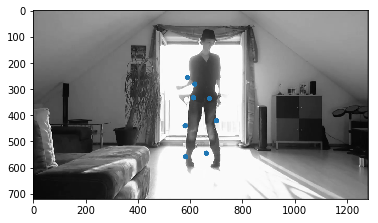

In [9]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.patches import Circle

dpi = 80
size = (original.size[0] / dpi, original.size[1] / dpi)

print(size)

frame = original.get_frame(t / fps)

fig = Figure(size, dpi)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
canvas = FigureCanvasAgg(fig)

ax = fig.gca()
ax.set_axis_off()
ax.set_aspect('equal')

ax.imshow(frame)



for i in range(0, m.shape[1]):
    circ = Circle(m[t][i], 10)
    ax.add_patch(circ)

canvas.draw()
# plt.show()

image = np.array(fig.canvas.renderer._renderer)

#plt.show()
plt.imshow(image)
print(image.shape, frame.shape)

In [10]:
animation = mpe.VideoClip(make_frame, duration=duration)

clip = mpe.clips_array([[original, animation]])
# clip.write_videofile('test.mp4', fps=fps)
# clip.ipython_display(fps=26, loop=True, autoplay=True)